In [1]:
from sympy import *
from collections import defaultdict
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
init_printing()

### Bspline basis

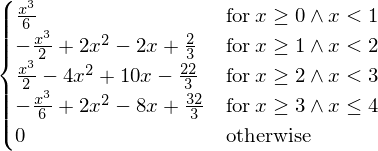

In [2]:
xs = Symbol('x')
knots = [0,1,2,3,4,5,6]

# Third-order bspline
sym_basis = bspline_basis_set(3, knots, xs)
# Form for one basis function
sym_basis[0]

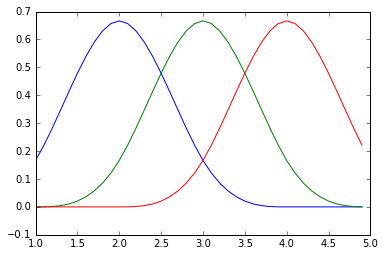

In [3]:
# Plot some basis functions
nbasis_to_plot = 3
npoints_to_plot = 40
basis_y = np.zeros((nbasis_to_plot, npoints_to_plot))
xvals = np.zeros(npoints_to_plot)
for i in range(npoints_to_plot):
    xv = i*.1 + 1.0
    for j in range(3):
        basis_y[j,i] = sym_basis[j].subs(xs,xv)
    xvals[i] = xv
plt.plot(xvals, basis_y[0,:], xvals, basis_y[1,:], xvals, basis_y[2,:])

### Function approximation
To fully represent an interval (say, 0.0 - 5.0, with a knot spacing of 1.0), we need parts of basis functions outside the interval as well.  To approximate a function, we evaluate at the M knots (there are 6 knots for this example).  There will be M+2 basis functions.

('Number of basis functions = ', 8)


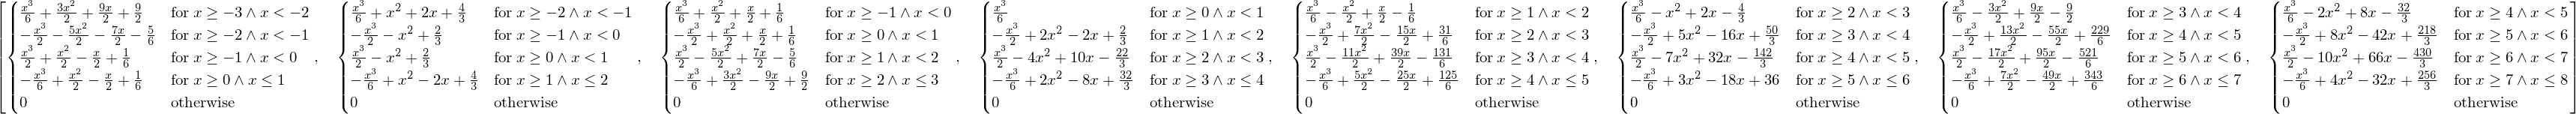

In [4]:
# Need knot values outside the target interval to generate the right set of basis functions.
knots = [0,1,2,3,4,5]
all_knots = [-3,-2,-1,0,1,2,3,4,5,6,7,8]

# Third-order bspline
sym_basis = bspline_basis_set(3, all_knots, xs)
print("Number of basis functions = ",len(sym_basis))
sym_basis

To approximate a function we need coefficients for each basis function 
$$
f(x) = \sum_0^{M+2} c_i B_i(x)
$$
The values of the function at the knots provides $M$ constraints.  We still need 2 more to fully specify the coefficients.   This is where the boundary conditions come into play.

$$
\sum_0^{M+2} c_i B_i(x_j) = g(x_j)
$$

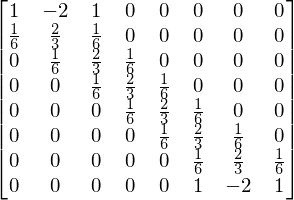

In [5]:
# Fill out the coefficient matrix
mat = Matrix.eye(len(knots)+2)
for i,k in enumerate(knots):
    for j,basis in enumerate(sym_basis):
        bv = basis.subs(xs,k)
        mat[i+1,j] = bv

# Natural boundary conditions - set 2nd derivative at end of range to zero
dd_spline = [diff(bs, xs, 2) for bs in sym_basis]

row0 = [dds.subs(xs, 0) for dds in dd_spline]
rowN = [dds.subs(xs, knots[-1]) for dds in dd_spline]
display(row0)
display(rowN)
for i in range(len(row0)):
    mat[0,i] = row0[i]
    mat[-1,i] = rowN[i]
mat


In [6]:
# Let us assume a simple quadratic function for interpolation
func_to_approx = [k*k for k in knots]
func_to_approx

### Solve for coefficients

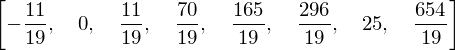

In [7]:
lhs_vals = [0] + func_to_approx + [0]  # Zeros are the value of the second derivative
coeffs = mat.LUsolve(Matrix(len(lhs_vals), 1, lhs_vals))
coeffs.T.tolist()[0]

### Evaluate the spline

In [8]:
def spline_eval(basis, coeffs, x):
    val = 0.0
    for c,bs in zip(coeffs, basis):
        val += c*bs.subs(xs,x)
    return val

In [9]:
# check that it reproduces the knots
for k,v in zip(knots,func_to_approx):
    print(k,spline_eval(sym_basis, coeffs, k),v)

(0, 0, 0)
(1, 1, 1)
(2, 4, 4)
(3, 9, 9)
(4, 16, 16)
(5, 25, 25)


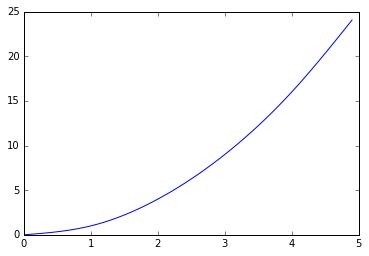

In [10]:
# Now check elsewhere
xvals = []
yvals = []
for i in range(50):
    x = .1*i
    val = spline_eval(sym_basis, coeffs, x)
    xvals.append(x)
    yvals.append(val)
plt.plot(xvals, yvals)
#plt.plot(xvals, yvals, knots, func_to_approx)

### Matching Einspline
The einspline code collects the values of each power of x in each interval.  The current form of the basis functions is a piecewise interval on the inside, and multiplication by the coefficients on the outside.  We would like to transpose this representation so that the intervals are on the outside, and the constributions from each coefficient are on the inside.  This will require some examination of the Sympy representation for intervals.

In [11]:
def to_interval(ival):
    """Convert relational expression to an Interval"""
    min_val = None
    lower_open = False
    max_val = None
    upper_open = True
    if isinstance(ival, And):
        for rel in ival.args:
            #print('rel ',rel, type(rel), rel.args[1])
            if isinstance(rel, StrictGreaterThan):
                min_val = rel.args[1]
                #lower_open = True
            elif isinstance(rel, GreaterThan):
                min_val = rel.args[1]
                #lower_open = False
            elif isinstance(rel, StrictLessThan):
                max_val = rel.args[1]
                #upper_open = True
            elif isinstance(rel, LessThan):
                max_val = rel.args[1]
                #upper_open = False
            else:
                print('unhandled ',rel)

    if min_val == None or max_val == None:
        print('error',ival)
    return Interval(min_val, max_val, lower_open, upper_open)

('Interval = ', Interval.Ropen(0, 1))


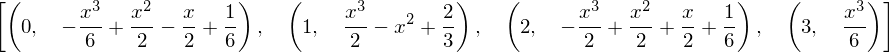

('Interval = ', Interval.Ropen(1, 2))


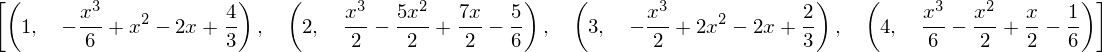

('Interval = ', Interval.Ropen(3, 4))


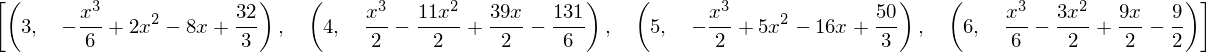

('Interval = ', Interval.Ropen(2, 3))


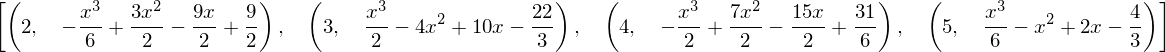

('Interval = ', Interval.Ropen(4, 5))


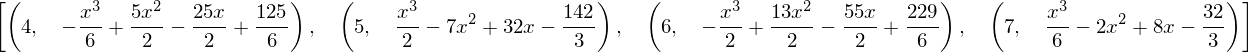

('Interval = ', Interval.Ropen(5, 6))


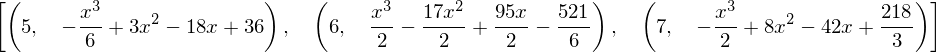

In [12]:
# Transpose the interval and coefficients
#  Note that interval [0,1) has the polynomial coefficients found in the einspline code
#  The other intervals could be shifted, and they would also have the same polynomials
def transpose_interval_and_coefficients(sym_basis):
    cond_map = defaultdict(list)

    i1 = Interval(0,5, False, False) # interval for evaluation
    for idx, s0 in enumerate(sym_basis):
        for expr, cond in s0.args:
            if cond != True:
                i2 = to_interval(cond)
                if not i1.is_disjoint(i2):
                    cond_map[i2].append( (idx, expr) )
    return cond_map

cond_map = transpose_interval_and_coefficients(sym_basis)
for cond, expr in cond_map.items():
    #print(cond, [e.subs(x, x-cond.args[0]) for e in expr])
    print("Interval = ",cond)
    # Shift interval to a common start - see that the polynomial coefficients are all the same
    #e2 = [expand(e[1].subs(xs, xs+cond.args[0])) for e in expr]
    e2 = [(idx,expand(e)) for idx, e in expr]
    display(e2)

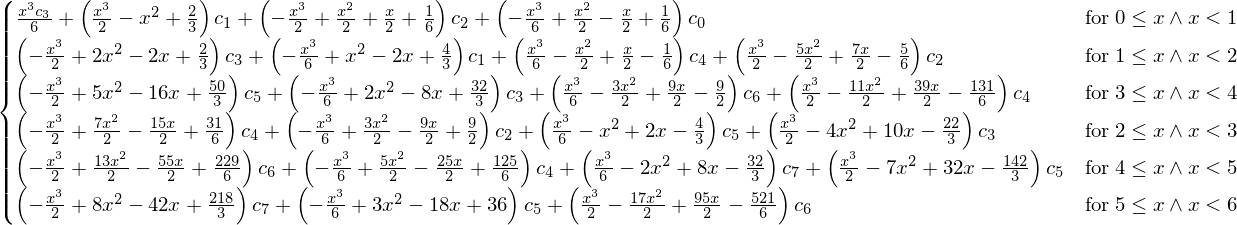

In [13]:
# Create piecewise expression from the transposed intervals
def recreate_piecewise(basis_map, c):
    args = []
    for cond, exprs in basis_map.items():
        e = 0
        for idx, b in exprs:
            e += c[idx] * b
        args.append( (e, cond.as_relational(xs)))
    return Piecewise(*args)

c = IndexedBase('c')
spline = recreate_piecewise(cond_map, c)
spline

In [14]:
def spline_eval2(spline, coeffs, x):
    """Evaluate spline using transposed expression"""
    val = 0.0
    c = IndexedBase('c')
    to_sub = {}
    for i,cf in enumerate(coeffs):
        to_sub[c[i]] = cf
    to_sub[xs] = x
    return spline.subs(to_sub)


In [15]:
for k in knots:
    val = spline_eval2(spline, coeffs, k)
    print(k,val)

(0, 0)
(1, 1)
(2, 4)
(3, 9)
(4, 16)
(5, 25)


## Bspline for Jastrow

For the radial part of the Jastrow factor, the derivative at $r=0$ is fixed by the cusp condition.   At $r=r_{cut}$, the value and derivatives are zero.

Also add the grid spacing, $\Delta$, to the knots.

In [16]:
Delta = Symbol('Delta',positive=True)
#knots = [0,1*Delta,2*Delta,3*Delta,4*Delta,5*Delta]
nknots = 6
knots = [i*Delta for i in range(nknots)]
display('knots = ',knots)
#all_knots = [-3*Delta,-2*Delta,-1*Delta,0,1*Delta,2*Delta,3*Delta,4*Delta,5*Delta,6*Delta,7*Delta,8*Delta]
all_knots = [i*Delta for i in range(-3,nknots+3)]
#display('all knots',all_knots)
rcut = (nknots-1)*Delta

# Third-order bspline
jastrow_sym_basis = bspline_basis_set(3, all_knots, xs)
print("Number of basis functions = ",len(jastrow_sym_basis))
#jastrow_sym_basis

'knots = '

('Number of basis functions = ', 8)


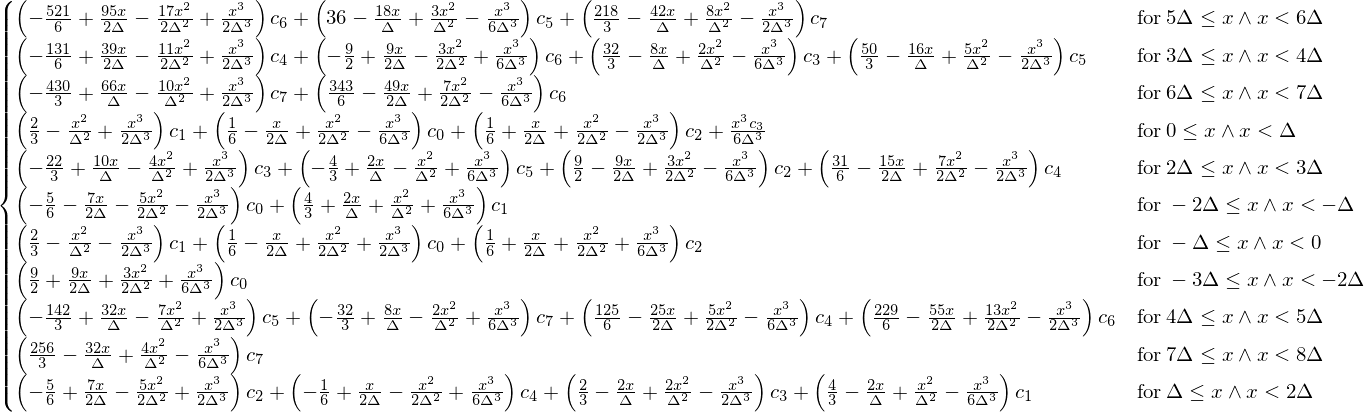

In [17]:
# Now create the spline from the basis functions
jastrow_cond_map = transpose_interval_and_coefficients(jastrow_sym_basis)
c = IndexedBase('c',shape=(nknots+3))
#c = MatrixSymbol('c',nknots+3,1)
jastrow_spline = recreate_piecewise(jastrow_cond_map, c)
jastrow_spline

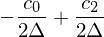

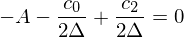

In [18]:
# Boundary conditions at r = 0 with the cusp (first derivative) condition

cusp_val = Symbol('A')
# Evaluate spline derivative at 0
du = diff(jastrow_spline,xs)
du_zero = du.subs(xs, 0)
display(du_zero)

# Solve following equation
display(Eq(du_zero-cusp_val,0))

# solve doesn't seem to work with Indexed value, substitute something else
c0 = Symbol('c0')
soln = solve(du_zero.subs(c[0],c0) - cusp_val, c0)
display(Eq(c0, soln[0]))

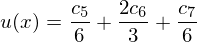

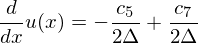

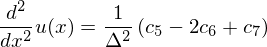

In [19]:
# Boundary conditions at r=r_cut.  For smoothness the value and derivatives should be 0.
# Add zero value and derivatives at r_cut
eq_v = jastrow_spline.subs(xs, rcut)
display(Eq(Symbol('u')(xs),eq_v))

eq_dv = diff(jastrow_spline, xs).subs(xs,rcut)
display(Eq(diff(Symbol('u')(xs),xs),eq_dv))

eq_ddv = diff(jastrow_spline, xs, 2).subs(xs,rcut)
display(Eq(diff(Symbol('u')(xs),xs,2),eq_ddv))

#eq_d3v = diff(jastrow_spline, xs, 3).subs(xs, rcut)
#display(eq_d3v)

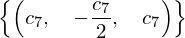

In [20]:
# Solve for all these equal to zero
c5 = Symbol('c5')
c6 = Symbol('c6')
c7 = Symbol('c7')
subs_list = {c[5]:c5, c[6]:c6, c[7]:c7}
linsolve([v.subs(subs_list) for v in [eq_v, eq_dv, eq_ddv]], [c5, c6, c7])
# QMCPACK enforces these conditions by setting c5, c6, c7 (the last three coefficients) to 0.